<a href="https://colab.research.google.com/github/OsaVS/cnn-realwaste/blob/simpler-model/custom_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Waste Material Classification using CNN

This notebook implements a Convolutional Neural Network to classify waste materials into 9 categories: Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, and Vegetation.


### Import Libraries

In [70]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import time

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


# Task
Download the dataset "rtti237/realwaste-dataset" from Kaggle, load it, and train a CNN model for waste classification.

## Install kaggle

### Subtask:
Install the Kaggle library in the notebook environment.


**Reasoning**:
The subtask is to install the Kaggle library. The instruction specifies using `pip install kaggle` in a code cell.



In [71]:
%pip install kaggle

## Set up kaggle credentials

### Subtask:
Guide the user on how to obtain their Kaggle API key and store it securely in the notebook environment.


**Reasoning**:
Provide instructions to the user on how to obtain their Kaggle API key and securely store it in the notebook environment.



In [72]:
print("Please follow these steps to obtain and store your Kaggle API key:")
print("1. Go to your Kaggle account settings.")
print("2. Under the 'API' section, click 'Create New API Token'. This will download a 'kaggle.json' file.")
print("3. In the notebook environment, navigate to the file explorer (usually a folder icon on the left sidebar).")
print("4. Click the upload button (usually an upward arrow icon) and upload the 'kaggle.json' file you just downloaded.")
print("5. Run the following code in a code cell to create the necessary directory and move the uploaded 'kaggle.json' file to that directory:")
print("\n!mkdir -p ~/.kaggle")
print("!mv kaggle.json ~/.kaggle/")
print("!chmod 600 ~/.kaggle/kaggle.json")

Please follow these steps to obtain and store your Kaggle API key:
1. Go to your Kaggle account settings.
2. Under the 'API' section, click 'Create New API Token'. This will download a 'kaggle.json' file.
3. In the notebook environment, navigate to the file explorer (usually a folder icon on the left sidebar).
4. Click the upload button (usually an upward arrow icon) and upload the 'kaggle.json' file you just downloaded.
5. Run the following code in a code cell to create the necessary directory and move the uploaded 'kaggle.json' file to that directory:

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [73]:
!mkdir -p ~/.kaggle

In [74]:
!mv kaggle.json ~/.kaggle/

mv: cannot stat 'kaggle.json': No such file or directory


In [75]:
!chmod 600 ~/.kaggle/kaggle.json

## Download dataset

### Subtask:
Write the code to download the specified dataset from Kaggle using the installed library and credentials.


**Reasoning**:
Download the specified dataset from Kaggle and unzip it.



In [76]:
import kaggle
kaggle.api.dataset_download_files('rtti237/realwaste-dataset', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/rtti237/realwaste-dataset


## Verify dataset location

### Subtask:
Show the user where the downloaded dataset is located in the notebook's file system.


**Reasoning**:
List the contents of the current directory to show the downloaded dataset files and folders.



In [77]:
%ls

RealWaste/  sample_data/  training_history.png


## Update data dir

### Subtask:
Modify the `DATA_DIR` variable to point to the location of the downloaded dataset.


**Reasoning**:
Update the DATA_DIR variable to the correct path of the downloaded dataset directory, which is 'RealWaste' in the current directory.



In [78]:
DATA_DIR = './RealWaste'
print(f"Updated DATA_DIR: {DATA_DIR}")

Updated DATA_DIR: ./RealWaste


## Dataset Configuration
- Resize the 524x524 to 224x224
- Set the batch size to 32. The number of data samples (images) that will be processed simultaneously during one forward/backward pass of the model
- Number of distinct classes for which the classification should be done is set to 9.
- Total number of epoch count is set to 20.

In [79]:
# Dataset parameters
IMAGE_SIZE = 224 # Updated image size
BATCH_SIZE = 32
NUM_CLASSES = 9
NUM_EPOCHS = 50

# Class names and their counts
CLASS_NAMES = [
    'Cardboard',         # 461
    'Food_Organics',     # 411
    'Glass',             # 420
    'Metal',             # 790
    'Miscellaneous',     # 495
    'Paper',             # 500
    'Plastic',           # 921
    'Textile',           # 318
    'Vegetation'         # 436
]

# DATA_DIR = '/home/ravindu/Documents/Projects/cnn-realwaste/realwaste/realwaste-main/RealWaste'

## Dataset class

In [80]:
class WasteDataset(Dataset):
    """Custom Dataset for loading waste material images"""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the class folders
            transform (callable, optional): Optional transform to be applied on images
        """
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.images = []
        self.labels = []

        # Load all images and labels
        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_dir = self.root_dir / class_name
            if class_dir.exists():
                for img_path in class_dir.glob('*.*'):
                    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        self.images.append(str(img_path))
                        self.labels.append(class_idx)

        print(f"Loaded {len(self.images)} images from {len(CLASS_NAMES)} classes")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

## Calculating normalization values
- Calculate μ and σ for each channel (R, G, B) of the specific training set using 1000 images from that dataset.

In [81]:
def calculate_mean_std(dataset_path, image_size=224, sample_size=None):
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor()
    ])

    temp_dataset = WasteDataset(root_dir=dataset_path, transform=transform)

    if sample_size and sample_size < len(temp_dataset):
        indices = np.random.choice(len(temp_dataset), sample_size, replace=False)
        temp_dataset = torch.utils.data.Subset(temp_dataset, indices)

    loader = DataLoader(temp_dataset, batch_size=32, shuffle=False, num_workers=4)

    channels_sum = torch.zeros(3)
    channels_squared_sum = torch.zeros(3)
    num_pixels = 0

    for images, _ in loader:
        channels_sum += torch.mean(images, dim=[0, 2, 3]) * images.size(0)
        channels_squared_sum += torch.mean(images ** 2, dim=[0, 2, 3]) * images.size(0)
        num_pixels += images.size(0)

    mean = channels_sum / num_pixels
    std = torch.sqrt(channels_squared_sum / num_pixels - mean ** 2)

    print(f"Dataset Mean (R, G, B): [{mean[0]:.4f}, {mean[1]:.4f}, {mean[2]:.4f}]")
    print(f"Dataset Std (R, G, B): [{std[0]:.4f}, {std[1]:.4f}, {std[2]:.4f}]")

    return mean.tolist(), std.tolist()

dataset_mean, dataset_std = calculate_mean_std(DATA_DIR, IMAGE_SIZE, sample_size=1000)

Loaded 3528 images from 9 classes
Dataset Mean (R, G, B): [0.5934, 0.6175, 0.6335]
Dataset Std (R, G, B): [0.1565, 0.1560, 0.1812]


## Data augmentation and pre-processing
### Training dataset
- Resizing
- Random horizontal flip
- Random rotation
- Color jitter (Randomly alter the brightness, contrast, and saturation)
- Convert the image from a PIL Image to a PyTorch Tensor and automatically scale pixel values from [0,255] to the floating-point range of [0.0,1.0]
- Standardize the Tensor data

### Validation data set
- Resizing
- Tensor conversion
- Normalization


In [82]:
# Train
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Changed from RandomResizedCrop
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std),
    transforms.RandomErasing(p=0.3, scale=(0.02,0.2), ratio=(0.3,3.3))
])

# Validation
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean, std=dataset_std)
])

## Load and split data set
- Load the full data set and split it into 70% training, 15% validation and 15% testing.
- Create the necessary data loaders

In [83]:
full_dataset = WasteDataset(root_dir=DATA_DIR, transform=train_transform)

total_size = len(full_dataset)
train_size = int(0.70 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

print(f"\nDataset Split:")
print(f"Training: {train_size} images ({train_size/total_size*100:.1f}%)")
print(f"Validation: {val_size} images ({val_size/total_size*100:.1f}%)")
print(f"Testing: {test_size} images ({test_size/total_size*100:.1f}%)")

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

# Apply appropriate transforms
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                       shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4, pin_memory=True)

Loaded 3528 images from 9 classes

Dataset Split:
Training: 2469 images (70.0%)
Validation: 529 images (15.0%)
Testing: 530 images (15.0%)


## CNN model architecture
### Feature Extraction

- Convo1ution layer 1: 32 filters, 5x5 kernel, ReLU activation
- MaxPool: 2x2
- Convo1ution layer 2: 64 filters, 3x3 kernel, ReLU activation
- MaxPool: 2x2
- Convo1ution layer 3: 128 filters, 3x3 kernel, ReLU activation (added for better feature extraction)
- MaxPool: 2x2

### Classification
- Flatten
- Fully Connected layer 1: 512 units, ReLU activation
    - with Dropout: 0.5
- Fully Connected layer 2: 256 units, ReLU activation
    - With Dropout: 0.3
- Output: 9 units, Softmax

In [84]:
class WasteCNN(nn.Module):

    def __init__(self, num_classes=9):
        super(WasteCNN, self).__init__()

        # Convolutional layers
        self.conv_layers = nn.Sequential(
            # First convolutional block
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Second convolutional block
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Third convolutional block
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1,1))
        )

        # Let's calculate the output size precisely after each layer for 524x524 input
        # Input: (Batch_size, 3, 524, 524)
        # Conv1: ((524 + 2*2 - 5)/1) + 1 = 524. Output: (Batch_size, 32, 524, 524)
        # MaxPool1: 524/2 = 262. Output: (Batch_size, 32, 262, 262)
        # Conv2: ((262 + 2*1 - 3)/1) + 1 = 262. Output: (Batch_size, 64, 262, 262)
        # MaxPool2: 262/2 = 131. Output: (Batch_size, 64, 131, 131)
        # Conv3: ((131 + 2*1 - 3)/1) + 1 = 131. Output: (Batch_size, 128, 131, 131)
        # MaxPool3: 131/2 = 65 (floor). Output: (Batch_size, 128, 65, 65)
        self.flatten_size = 128 * 1 * 1


        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )


        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize model weights using He initialization"""

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Create model and move to GPU
model = WasteCNN(num_classes=NUM_CLASSES).to(device)

print("\n" + "="*70)
print("MODEL ARCHITECTURE")
print("="*70)
print(model)
print("\nTotal parameters:", sum(p.numel() for p in model.parameters()))
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))


MODEL ARCHITECTURE
WasteCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): ReL

## Loss function and Optimizer
- Loss function -> Cross entropy loss
- Optimizer -> Adaptive Moment Estimation (ADAM)
- Learning rate scheduler -> Reduce LR On Plateau

In [85]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

## Training and Validation

In [86]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train the model for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

def validate_epoch(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

## Training Loop

In [87]:
# Lists to store history
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_loss = float('inf')
best_model_state = None

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start_time = time.time()

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)

    # Store history
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # Learning rate scheduling
    scheduler.step(val_loss)

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict().copy()

    epoch_time = time.time() - epoch_start_time

    # Print progress
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] ({epoch_time:.2f}s) - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

total_time = time.time() - start_time
print(f"\nTraining completed in {total_time/60:.2f} minutes")

model.load_state_dict(best_model_state)

Epoch [1/50] (23.97s) - Train Loss: 1.6811, Train Acc: 33.37% | Val Loss: 1.3915, Val Acc: 47.07%
Epoch [2/50] (17.44s) - Train Loss: 1.3903, Train Acc: 41.88% | Val Loss: 1.3812, Val Acc: 41.78%
Epoch [3/50] (17.29s) - Train Loss: 1.2781, Train Acc: 48.12% | Val Loss: 1.2420, Val Acc: 54.44%
Epoch [4/50] (17.92s) - Train Loss: 1.1670, Train Acc: 53.79% | Val Loss: 1.0315, Val Acc: 62.38%
Epoch [5/50] (17.31s) - Train Loss: 1.0991, Train Acc: 58.44% | Val Loss: 1.0713, Val Acc: 59.74%
Epoch [6/50] (17.51s) - Train Loss: 1.0582, Train Acc: 59.50% | Val Loss: 0.9298, Val Acc: 65.78%
Epoch [7/50] (18.68s) - Train Loss: 1.0146, Train Acc: 61.97% | Val Loss: 0.9156, Val Acc: 64.65%
Epoch [8/50] (17.29s) - Train Loss: 0.9879, Train Acc: 62.05% | Val Loss: 0.8881, Val Acc: 69.00%
Epoch [9/50] (17.09s) - Train Loss: 0.9661, Train Acc: 63.02% | Val Loss: 1.0821, Val Acc: 60.30%
Epoch [10/50] (18.18s) - Train Loss: 0.9166, Train Acc: 65.74% | Val Loss: 0.8532, Val Acc: 66.73%
Epoch [11/50] (17.1

<All keys matched successfully>

## Training history graphs

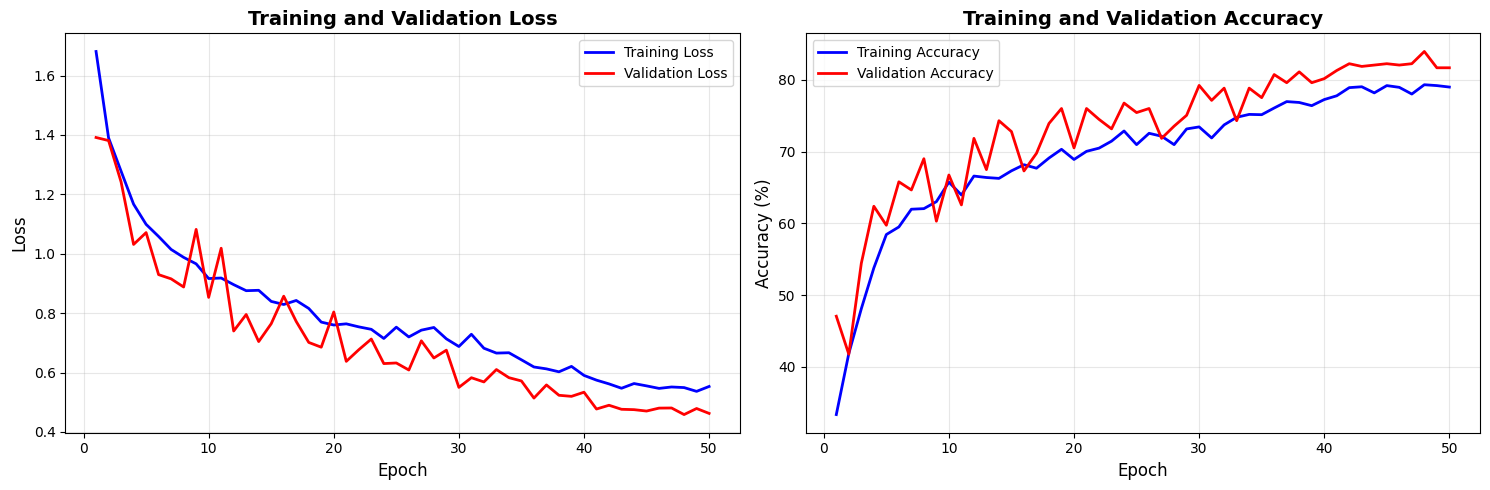


Best validation loss: 0.4586


In [88]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
axes[0].plot(range(1, NUM_EPOCHS+1), train_losses, 'b-', label='Training Loss', linewidth=2)
axes[0].plot(range(1, NUM_EPOCHS+1), val_losses, 'r-', label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(range(1, NUM_EPOCHS+1), train_accs, 'b-', label='Training Accuracy', linewidth=2)
axes[1].plot(range(1, NUM_EPOCHS+1), val_accs, 'r-', label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nBest validation loss: {best_val_loss:.4f}")

## Evaluation on test set

In [89]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate test accuracy
test_accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
print(f"\nTest Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 76.79%
